In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.model_selection import train_test_split
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# __Contents:__<br> 1.Data Preparation <br> 2.Outliers Detection & Data Analysis <br> 3.Correlation Analysis & Multicollinearity <br> 4.Regression Analysis - with Interaction <br>5.Simple Linear Regression Analysis <br>6.Linear Regression Analysis with Dummy variables <br>7.XGBoost model <br>8.Final Model<br>9.Building a Predictive System

# 1.Data Preparation

In [109]:
# Read a CSV file
calories = pd.read_csv('calories.csv')
calories.head()

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0


In [110]:
exercise = pd.read_csv('exercise.csv')
exercise.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


In [111]:
# Merge the two data sets on User_ID
data = exercise.merge(calories, how = 'left', on = 'User_ID')
data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [112]:
# Describe the merged data
data.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [113]:
# Replace all blank spaces in columns' names
data.columns = data.columns.str.replace(' ', '')

In [114]:
data.columns

Index(['User_ID', 'Gender', 'Age', 'Height', 'Weight', 'Duration',
       'Heart_Rate', 'Body_Temp', 'Calories'],
      dtype='object')

In [115]:
# Data Types Information
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.1+ MB


In [116]:
# Replace all blank spaces in a dataframe
data_obj = data.select_dtypes(['object'])
data[data_obj.columns] = data_obj.apply(lambda x: x.str.strip())
data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [121]:
# Check for Null values
data.isna().sum()

User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

# 2.Outliers Detection & Data Analysis

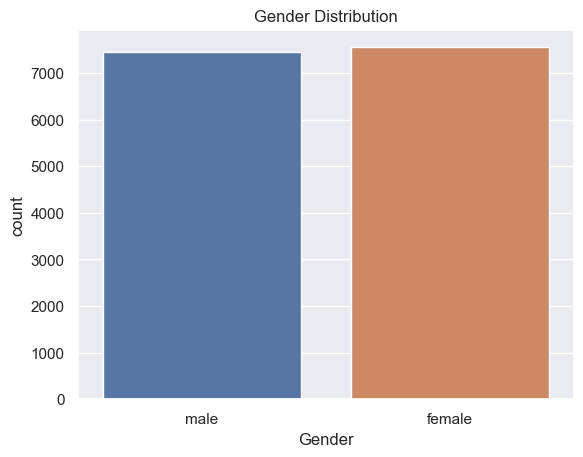

In [123]:
# Gender Distribution
sns.set()
sns.countplot(x = 'Gender', data = data)
plt.title('Gender Distribution')
plt.show()

In [124]:
data['Gender'].value_counts()

female    7553
male      7447
Name: Gender, dtype: int64

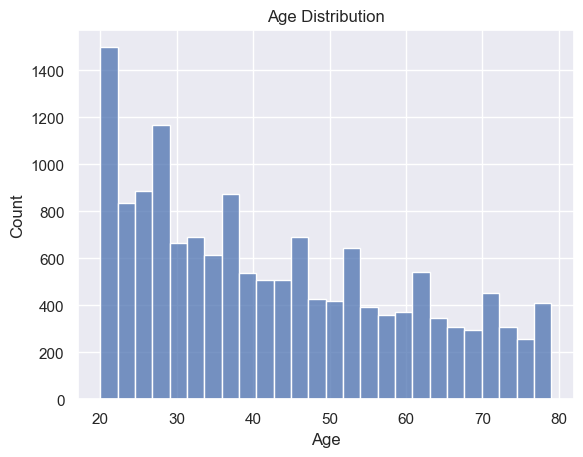

In [10]:
# Age Distribution
sns.histplot(data['Age'])
plt.title('Age Distribution')
plt.show()

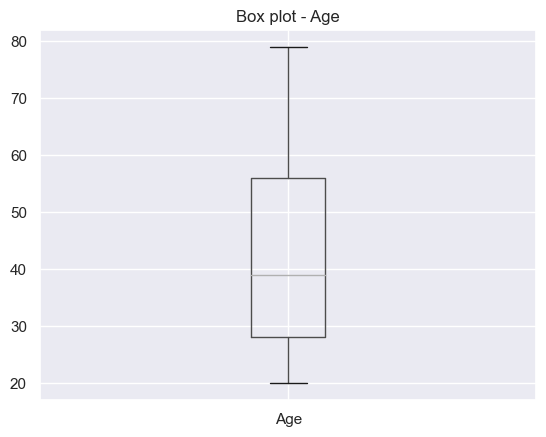

In [11]:
data.boxplot('Age')
plt.title('Box plot - Age')
plt.show()

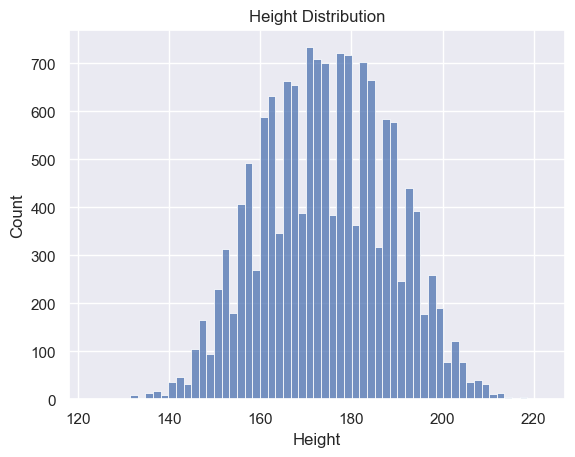

In [12]:
# Height Distribution
sns.histplot(data['Height'])
plt.title('Height Distribution')
plt.show()

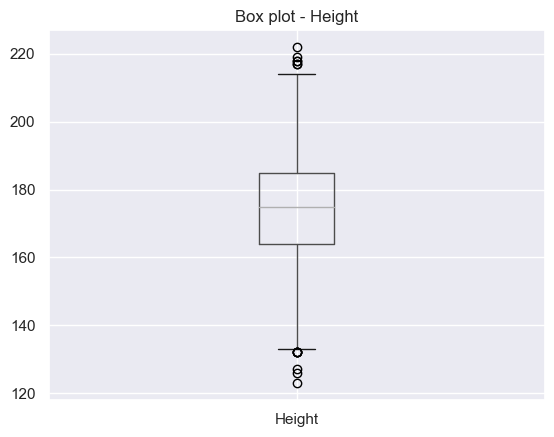

In [13]:
data.boxplot('Height')
plt.title('Box plot - Height')
plt.show()

In [14]:
# Sort values for Outliers Detection
height_asc = data.Height.sort_values(ascending = True)
height_asc.head(50)

4200     123.0
7774     126.0
6226     127.0
13100    132.0
4855     132.0
529      132.0
8931     132.0
4404     132.0
1054     133.0
8130     133.0
11422    133.0
11786    134.0
8850     134.0
5868     135.0
958      135.0
5579     135.0
6963     135.0
8126     135.0
1896     135.0
9219     135.0
2113     136.0
112      136.0
5246     136.0
14134    136.0
14170    136.0
2007     137.0
6835     137.0
11804    137.0
10692    137.0
7379     137.0
12923    137.0
8603     138.0
5090     138.0
1668     138.0
1770     138.0
1213     138.0
13800    138.0
14875    138.0
4350     138.0
3668     138.0
8328     138.0
1082     139.0
11534    139.0
10540    139.0
13851    139.0
8035     139.0
13816    139.0
9401     139.0
3859     139.0
1703     139.0
Name: Height, dtype: float64

In [15]:
index_outliers = data.loc[data.Height < 132].index
index_outliers

Int64Index([4200, 6226, 7774], dtype='int64')

In [16]:
# Data Correction
data.loc[data.Height < 132, 'Height'] = 132 
data.loc[index_outliers]

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
4200,17172665,female,63,132.0,40.0,9.0,97.0,39.9,55.0
6226,11581936,female,58,132.0,40.0,29.0,102.0,40.8,189.0
7774,18699424,female,30,132.0,39.0,25.0,104.0,40.7,156.0


In [17]:
# Sort values for Outliers Detection
data.Height.sort_values(ascending = True)

13100    132.0
4200     132.0
6226     132.0
4855     132.0
529      132.0
         ...  
1464     217.0
6711     218.0
12360    218.0
12189    219.0
10362    222.0
Name: Height, Length: 15000, dtype: float64

In [18]:
height_dsc = data.Height.sort_values(ascending = False)
height_dsc.head(50)

10362    222.0
12189    219.0
6711     218.0
12360    218.0
13276    217.0
1464     217.0
4865     214.0
12398    214.0
13950    214.0
13806    214.0
2098     213.0
5662     213.0
12969    213.0
11305    213.0
6209     213.0
9088     213.0
2043     212.0
2814     212.0
697      212.0
4936     212.0
6742     212.0
14627    212.0
1909     212.0
5163     211.0
13543    211.0
9542     211.0
6578     211.0
6402     211.0
8536     211.0
1626     211.0
2976     211.0
1498     211.0
5968     211.0
2139     210.0
3312     210.0
10987    210.0
10926    210.0
5176     210.0
10788    210.0
5061     210.0
12854    210.0
8900     210.0
4708     210.0
13960    210.0
8527     210.0
10238    210.0
13185    210.0
3490     210.0
8212     210.0
1187     209.0
Name: Height, dtype: float64

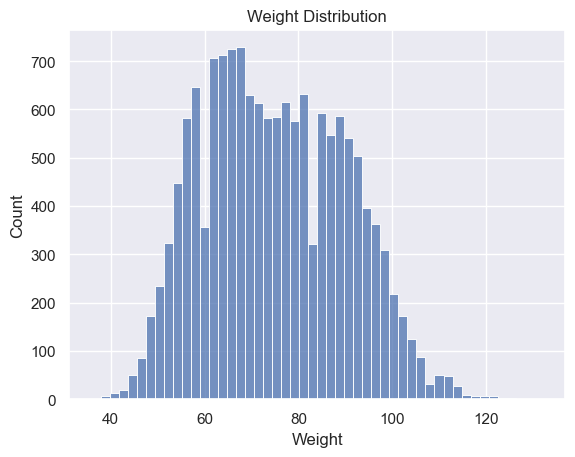

In [19]:
# Weight Distribution
sns.histplot(data['Weight'])
plt.title('Weight Distribution')
plt.show()

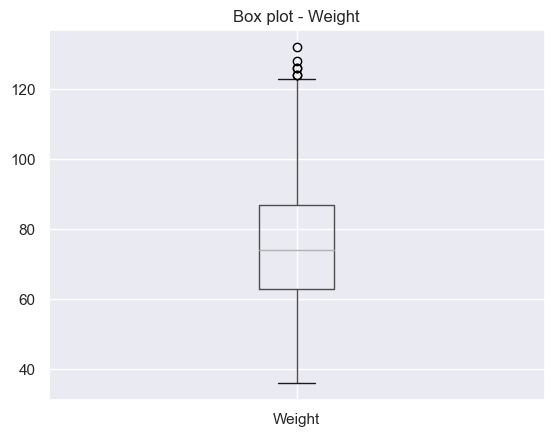

In [20]:
data.boxplot('Weight')
plt.title('Box plot - Weight')
plt.show()

In [21]:
# Sort values for Outliers Detection
weight_dsc = data.Weight.sort_values(ascending = False)
weight_dsc.head(50)

6711     132.0
10362    128.0
12189    126.0
13276    126.0
1909     124.0
13806    124.0
14627    123.0
3490     122.0
5662     121.0
5177     121.0
8527     121.0
6578     121.0
10926    121.0
4436     120.0
9088     119.0
8899     119.0
12854    119.0
11305    119.0
12360    119.0
1464     118.0
2814     118.0
8212     117.0
10424    117.0
7751     117.0
3312     117.0
6416     117.0
8189     116.0
5176     116.0
13543    116.0
6402     116.0
8536     116.0
4936     115.0
10680    115.0
13960    115.0
502      115.0
7204     114.0
7876     114.0
2299     114.0
11889    114.0
7184     114.0
12124    114.0
7451     114.0
3702     114.0
10788    114.0
13494    114.0
10253    114.0
5061     114.0
4948     114.0
894      114.0
5861     114.0
Name: Weight, dtype: float64

In [22]:
index_outliers = data.loc[data.Weight > 128].index
index_outliers

Int64Index([6711], dtype='int64')

In [23]:
# Data Correction
data.loc[data.Weight > 128,'Weight'] = 128.0
data.loc[index_outliers]

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
6711,12623721,male,40,218.0,128.0,1.0,88.0,37.8,5.0


In [24]:
# Sort values for Outliers Detection
data.Weight.sort_values(ascending = False)

10362    128.0
6711     128.0
12189    126.0
13276    126.0
1909     124.0
         ...  
11786     38.0
529       38.0
1896      38.0
8130      38.0
8931      36.0
Name: Weight, Length: 15000, dtype: float64

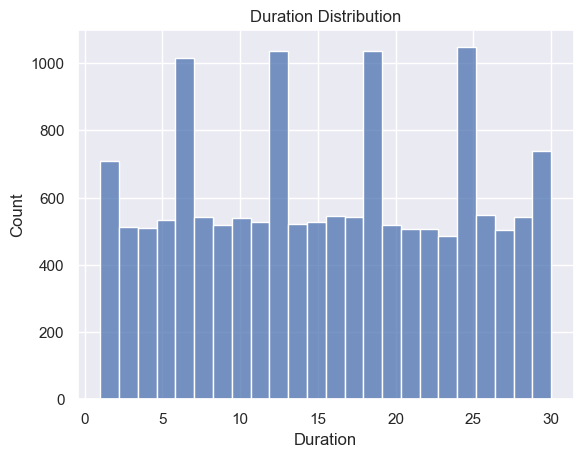

In [25]:
# Duration Distribution
sns.histplot(data['Duration'])
plt.title('Duration Distribution')
plt.show()

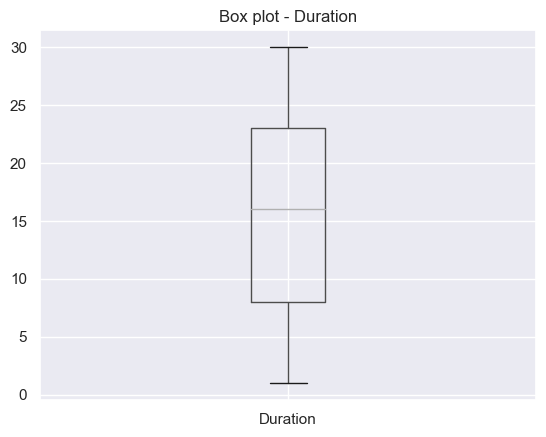

In [26]:
data.boxplot('Duration')
plt.title('Box plot - Duration')
plt.show()

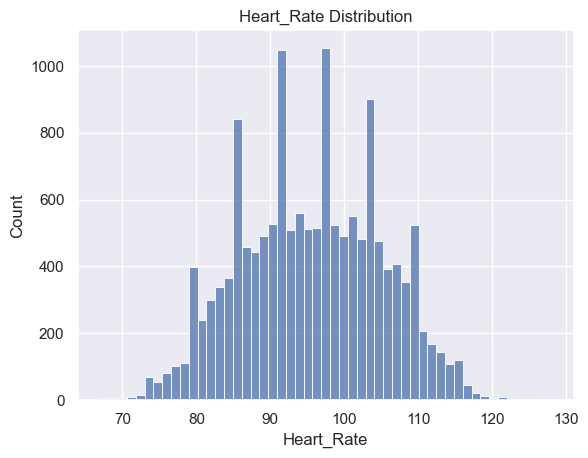

In [27]:
# Heart Rate Distribution
sns.histplot(data['Heart_Rate'])
plt.title('Heart_Rate Distribution')
plt.show()

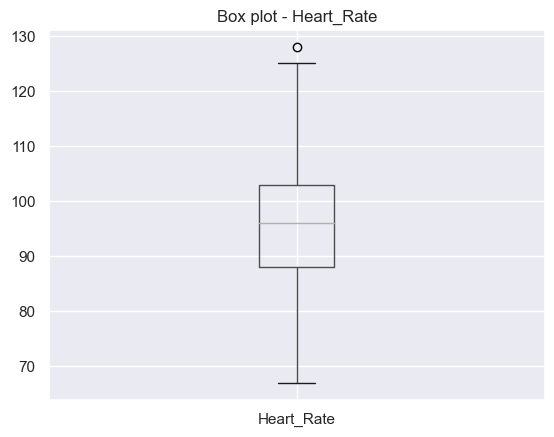

In [28]:
data.boxplot('Heart_Rate')
plt.title('Box plot - Heart_Rate')
plt.show()

In [29]:
# Sort values for Outliers Detection
heart_rate_dsc = data.Heart_Rate.sort_values(ascending = False)
heart_rate_dsc.head(10)

9981     128.0
5097     125.0
3357     125.0
428      123.0
11345    122.0
10347    122.0
2706     122.0
14408    121.0
1444     121.0
6240     121.0
Name: Heart_Rate, dtype: float64

In [30]:
index_outliers = data.loc[data.Heart_Rate > 125].index
index_outliers

Int64Index([9981], dtype='int64')

In [31]:
# Data Correction
data.loc[data.Heart_Rate > 125,'Heart_Rate'] = 125.0
data.loc[index_outliers]

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
9981,12114332,male,32,188.0,91.0,30.0,125.0,40.9,289.0


In [32]:
data.Heart_Rate.sort_values(ascending = False)

9981     125.0
5097     125.0
3357     125.0
428      123.0
11345    122.0
         ...  
8083      68.0
5425      68.0
4400      67.0
2864      67.0
2509      67.0
Name: Heart_Rate, Length: 15000, dtype: float64

In [33]:
data.Heart_Rate.sort_values(ascending = True)

2864      67.0
4400      67.0
2509      67.0
5425      68.0
8083      68.0
         ...  
11345    122.0
428      123.0
5097     125.0
9981     125.0
3357     125.0
Name: Heart_Rate, Length: 15000, dtype: float64

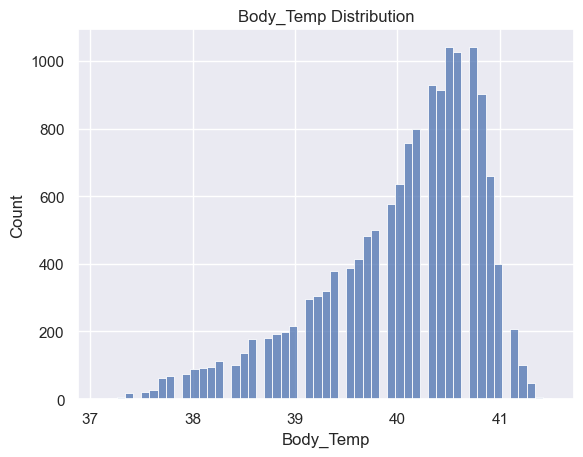

In [34]:
# Body Temp Distribution
sns.histplot(data['Body_Temp'])
plt.title('Body_Temp Distribution')
plt.show()

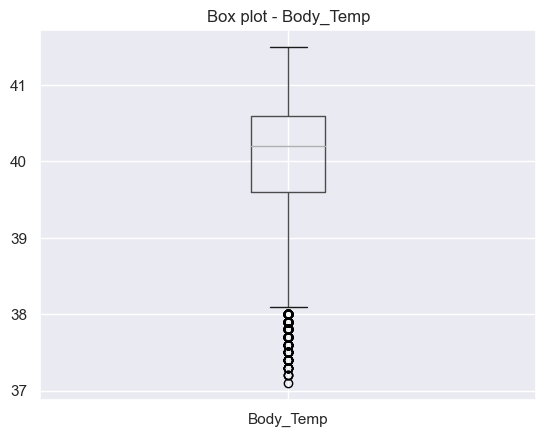

In [35]:
data.boxplot('Body_Temp')
plt.title('Box plot - Body_Temp')
plt.show()

In [36]:
# Sort values for Outlier Detection
body_temp_asc = data.Body_Temp.sort_values(ascending = True)
body_temp_asc.head(50)

6989     37.1
7573     37.2
5403     37.2
13208    37.2
9693     37.3
4703     37.3
7628     37.3
1964     37.3
11365    37.3
4113     37.3
4457     37.3
8637     37.4
3621     37.4
14900    37.4
13230    37.4
7724     37.4
12842    37.4
5402     37.4
13853    37.4
8969     37.4
8219     37.4
1446     37.4
14382    37.4
2433     37.4
5320     37.4
14515    37.4
11897    37.4
10554    37.4
3677     37.5
8341     37.5
4477     37.5
6744     37.5
8295     37.5
2763     37.5
4541     37.5
14669    37.5
1198     37.5
7468     37.5
11638    37.5
2849     37.5
12594    37.5
9022     37.5
12621    37.5
14147    37.5
906      37.5
12114    37.5
8671     37.5
13211    37.5
13417    37.5
13423    37.5
Name: Body_Temp, dtype: float64

In [37]:
filter_ = data.Body_Temp < 38
data[filter_]

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
10,13723164,female,36,177.0,76.0,1.0,74.0,37.8,3.0
24,14893804,male,48,182.0,85.0,1.0,80.0,37.7,3.0
232,19911268,male,45,195.0,99.0,2.0,83.0,37.9,7.0
301,17029728,female,31,169.0,69.0,1.0,74.0,37.6,3.0
317,17001911,female,36,164.0,57.0,2.0,79.0,37.9,7.0
...,...,...,...,...,...,...,...,...,...
14568,10831168,male,58,187.0,87.0,1.0,80.0,37.7,4.0
14669,19612729,female,30,154.0,55.0,1.0,86.0,37.5,4.0
14732,13196720,male,44,175.0,74.0,1.0,74.0,37.9,2.0
14749,13065291,male,70,150.0,59.0,1.0,80.0,37.9,4.0


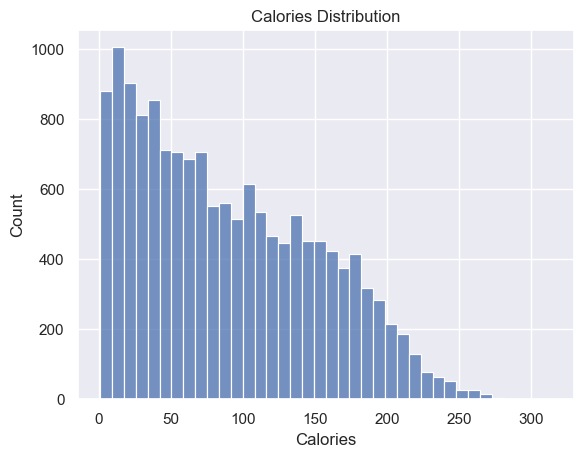

In [38]:
# Calories Distributiom
sns.histplot(data['Calories'])
plt.title('Calories Distribution')
plt.show()

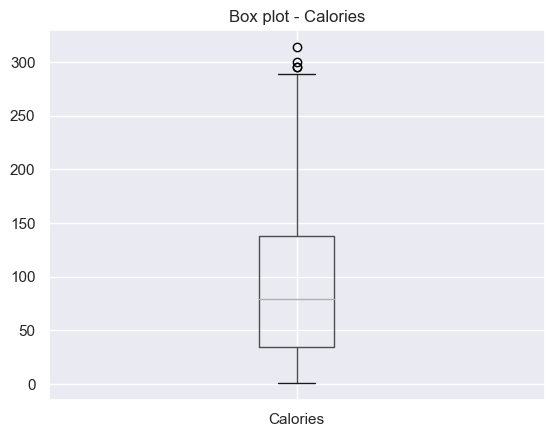

In [39]:
data.boxplot('Calories')
plt.title('Box plot - Calories')
plt.show()

In [40]:
# Sort Values fot Outliers Detection
calories_dsc = data.Calories.sort_values(ascending = False)
calories_dsc.head(20)

428      314.0
6240     300.0
13871    295.0
3357     295.0
9981     289.0
14001    287.0
3450     280.0
1661     276.0
12330    276.0
9191     273.0
6979     272.0
1444     271.0
11514    271.0
1145     270.0
8558     269.0
7755     268.0
14111    268.0
5127     266.0
5662     266.0
1665     266.0
Name: Calories, dtype: float64

In [41]:
filter_ = data.Calories > 285
data[filter_]

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
428,13079051,male,75,199.0,103.0,28.0,123.0,40.5,314.0
3357,17825244,male,65,189.0,98.0,27.0,125.0,40.9,295.0
6240,17545969,male,69,193.0,90.0,29.0,121.0,41.1,300.0
9981,12114332,male,32,188.0,91.0,30.0,125.0,40.9,289.0
13871,10784322,male,75,178.0,76.0,29.0,120.0,40.8,295.0
14001,19360607,male,72,191.0,97.0,29.0,116.0,41.0,287.0


In [42]:
# Data Correction
data.loc[data.Calories == 314, 'Calories'] = 300

In [43]:
data.loc[data.Calories > 295]

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
428,13079051,male,75,199.0,103.0,28.0,123.0,40.5,300.0
6240,17545969,male,69,193.0,90.0,29.0,121.0,41.1,300.0


# 3.Correlation Analysis & Multicollinearity

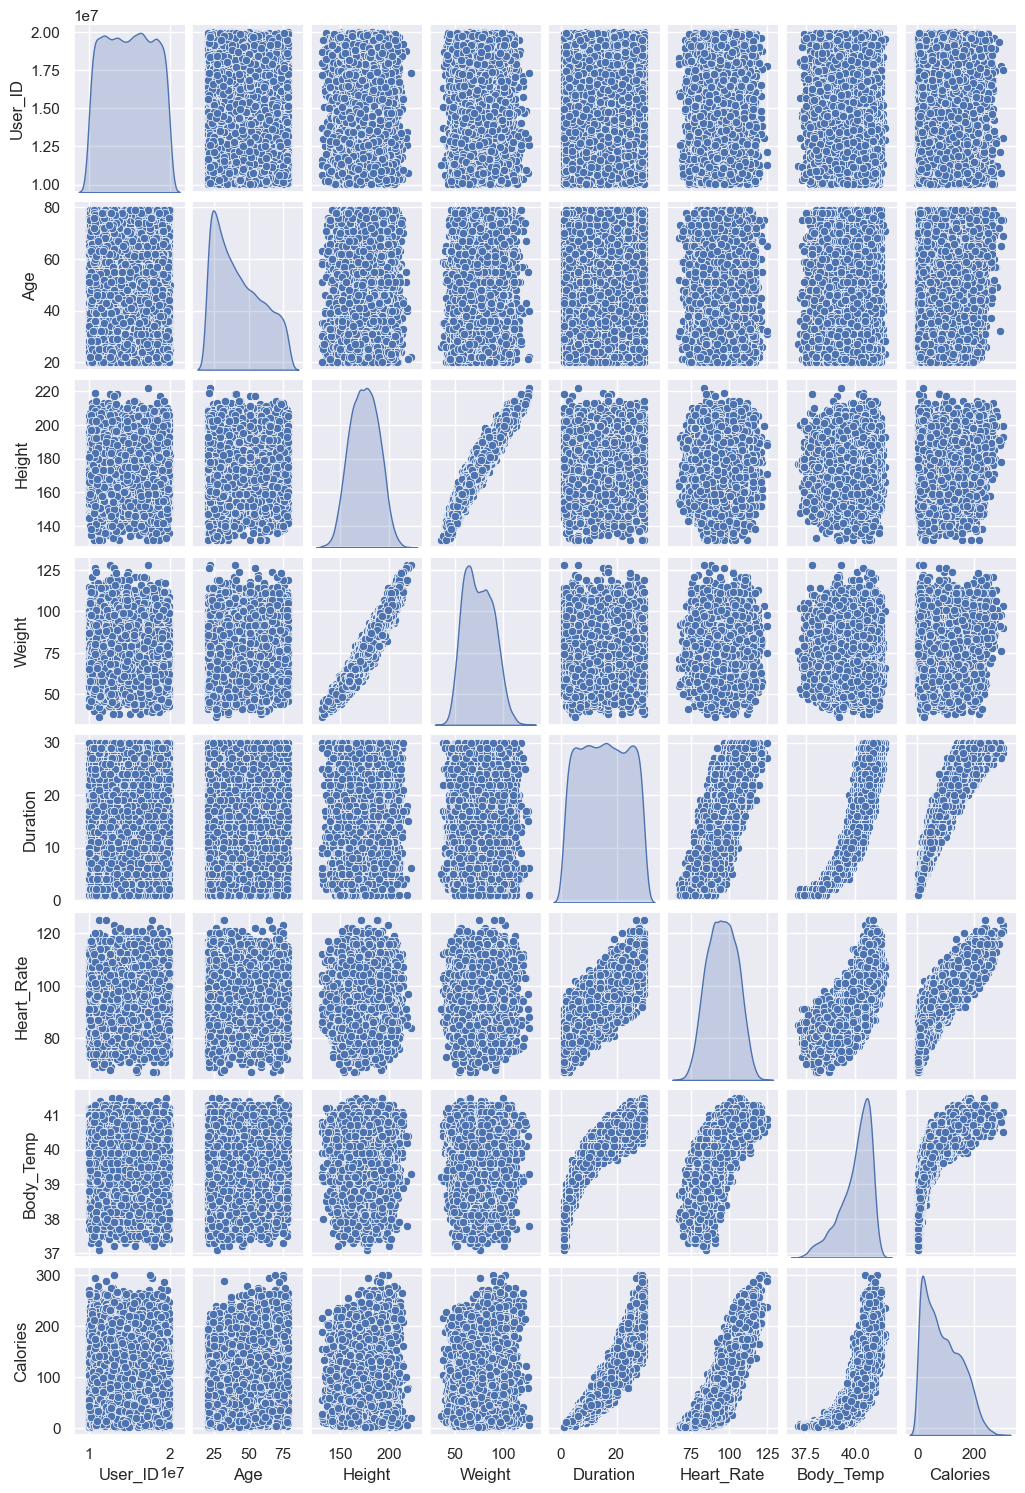

In [44]:
g = sns.pairplot(data,diag_kind='kde')
g.fig.set_size_inches(10,15)

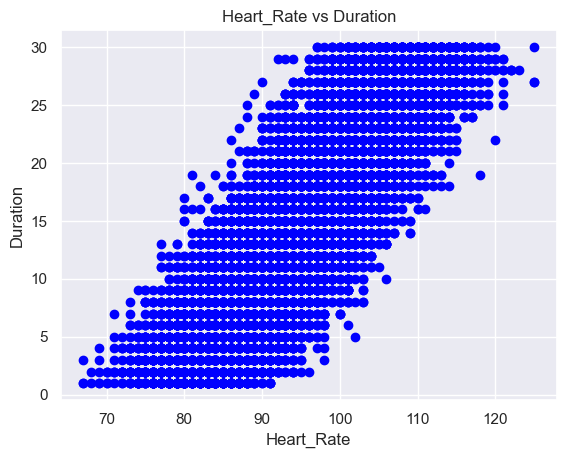

In [45]:
plt.scatter(data['Heart_Rate'], data['Duration'],  color = 'blue')
plt.ylabel('Duration')
plt.xlabel('Heart_Rate')
plt.title('Heart_Rate vs Duration')
plt.show()

__There is a strong correlation between Heart_Rate and Duration.__

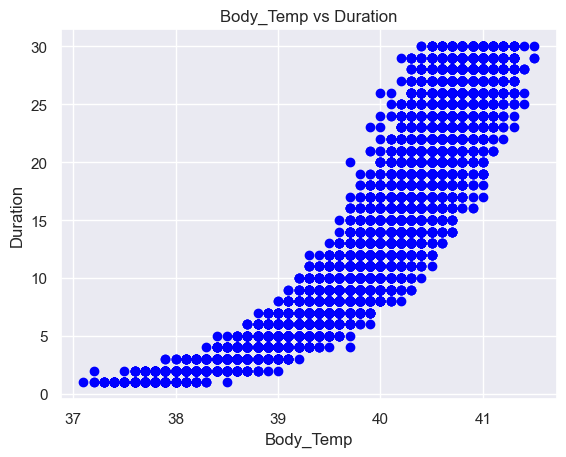

In [47]:
plt.scatter(data['Body_Temp'], data['Duration'],  color = 'blue')
plt.ylabel('Duration')
plt.xlabel('Body_Temp')
plt.title('Body_Temp vs Duration')
plt.show()

__There is a strong correlation between Body_Temp and Duration.__

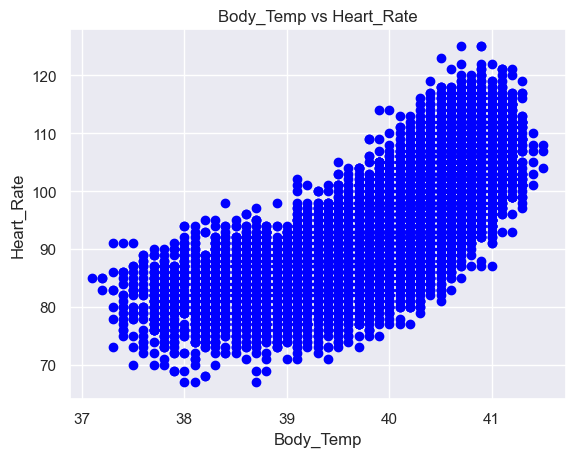

In [49]:
plt.scatter(data['Body_Temp'], data['Heart_Rate'], color = 'blue')
plt.ylabel('Heart_Rate')
plt.xlabel('Body_Temp')
plt.title('Body_Temp vs Heart_Rate')
plt.show()

__There is a strong correlation between Body_Temp and Heart_Rate.__

In [51]:
data_no_nulls = data[["Duration", "Body_Temp", "Heart_Rate", "Calories"]].dropna().copy()
data_no_nulls.corr()

,Duration,Body_Temp,Heart_Rate,Calories
Duration,1.000000,0.903167,0.852890,0.955448
Body_Temp,0.903167,1.000000,0.771557,0.824592
Heart_Rate,0.852890,0.771557,1.000000,0.897880
Calories,0.955448,0.824592,0.897880,1.000000


# 4.Regression Analysis - with Interaction

__When interaction between two variables is present, we cannot study the effect of one variable on the response y independently of the other variable.
In other words, meaningful conclusions can be developed only if we consider the joint effect that both variables have on the response. <br>
y = b0 + b1x1 + b2x2 + b3x1x2 + e <br>
y = Calories (IBS) <br>
x1 = Duration (Min) <br>
x2 = Heart_Rate (Beats per minute)<br>
Estimated Regression Equation <br>
y = z0 + b1z1 + b2z2 + b3z3 <br>
z3 = z1 * z2 <br>
z3 is the Interaction variable__


In [52]:
z1 = data['Duration']
z2 = data['Heart_Rate']
z3 = z1 * z2

In [53]:
x_new = np.column_stack((z1,z2,z3))
y = data['Calories']
xnew2 = sm.add_constant(x_new)
model2 = sm.OLS(y, xnew2)
Model2 = model2.fit()
print(Model2.summary())

                            OLS Regression Results                            
Dep. Variable:               Calories   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                 1.266e+05
Date:                Thu, 27 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:36:38   Log-Likelihood:                -58771.
No. Observations:               15000   AIC:                         1.175e+05
Df Residuals:                   14996   BIC:                         1.176e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1869      2.480      0.882      0.3

__Overall the model is statistically significant, because Prob (F-statistic) is 0.00, but Heart Rate has a p value of 0.377 which is not statistically significant. Therefore there is a better model fоr predicting burnt calories.__

In [54]:
z1 = data['Duration']
z2 = data['Body_Temp']
z3 = z1 * z2

In [55]:
x_new2 = np.column_stack((z1,z2,z3))
y = data['Calories']
xnew3 = sm.add_constant(x_new2)
model3 = sm.OLS(y, xnew3)
Model3 = model3.fit()
print(Model3.summary())

                            OLS Regression Results                            
Dep. Variable:               Calories   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                 6.260e+04
Date:                Thu, 27 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:36:38   Log-Likelihood:                -63767.
No. Observations:               15000   AIC:                         1.275e+05
Df Residuals:                   14996   BIC:                         1.276e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        636.5741     16.057     39.644      0.0

__Calories =  636.5741 - 34.3068 * Duration -16.7044 * Body_Temp + 1.0429 Duration * Body_Temp__

__The regression results show that the effect of Body_Temp on Calories depends on the Duration.__

In [56]:
E = Model3.resid_pearson
E

array([ 2.17500191, -0.32241496,  0.3312554 , ..., -0.70187642,
        0.17282629, -0.2809963 ])

In [57]:
yhat = Model3.predict(xnew3)
yhat

array([194.05711981,  71.47628823,  20.37355501, ...,  86.92152359,
         8.0645079 , 102.77278319])

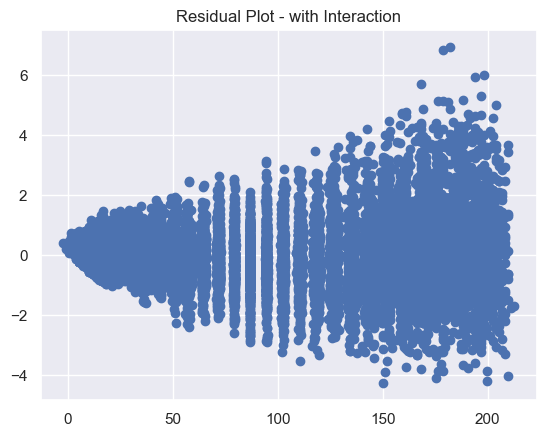

In [58]:
plt.scatter(yhat,E)
plt.title('Residual Plot - with Interaction')
plt.show()

__We can see a pattern in the residual plot therefore the model is not valid or need improvement. <br> There is no homogeneity of variances.__

# 5.Simple Linear Regression Analysis

In [59]:
Reg1 = ols(formula = "Calories ~ Duration", data = data)
fit1 = Reg1.fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:               Calories   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 1.572e+05
Date:                Thu, 27 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:36:38   Log-Likelihood:                -64996.
No. Observations:               15000   AIC:                         1.300e+05
Df Residuals:                   14998   BIC:                         1.300e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -21.8580      0.319    -68.569      0.0

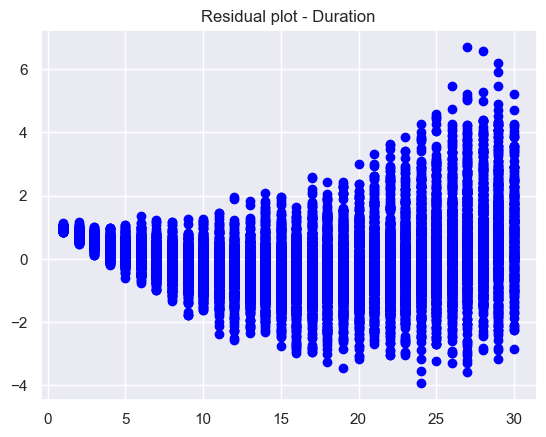

In [60]:
# Residual Analysis
influence = fit1.get_influence()
resid_student = influence.resid_studentized_external
plt.figure()
plt.scatter(data['Duration'], resid_student, color = "blue")
plt.title('Residual plot - Duration')
plt.show()

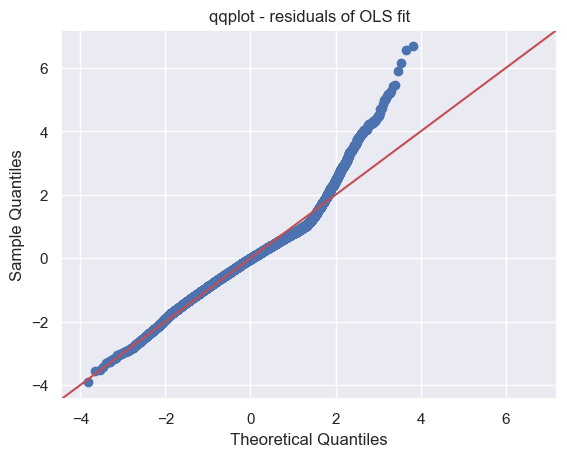

In [61]:
res = fit1.resid # residuals
probplot = sm.ProbPlot(res, stats.norm, fit = True)
fig = probplot.qqplot(line = '45')
h = plt.title('qqplot - residuals of OLS fit')
plt.show()

__Result:<br>
There is a pattern in Residual plots.<br>
There is a problem in the assumption or another variable can affect the burnt calories.<br>__

In [62]:
Reg2 = ols(formula = "Calories ~ Body_Temp", data = data)
fit2 = Reg2.fit()
print(fit2.summary())

                            OLS Regression Results                            
Dep. Variable:               Calories   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                 3.186e+04
Date:                Thu, 27 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:37:18   Log-Likelihood:                -74755.
No. Observations:               15000   AIC:                         1.495e+05
Df Residuals:                   14998   BIC:                         1.495e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2555.7185     14.822   -172.429      0.0

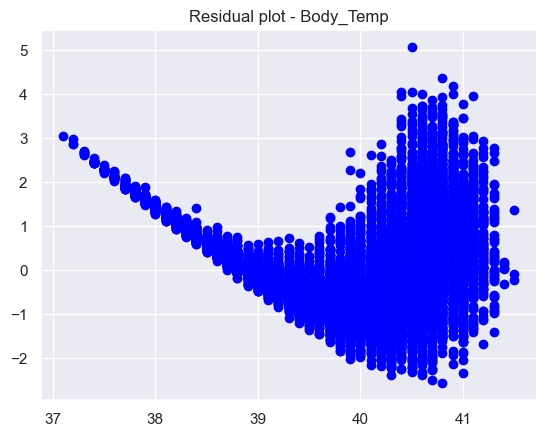

In [63]:
influence = fit2.get_influence()
resid_student = influence.resid_studentized_external
plt.figure()
plt.scatter(data['Body_Temp'], resid_student, color = "blue")
plt.title('Residual plot - Body_Temp')
plt.show()

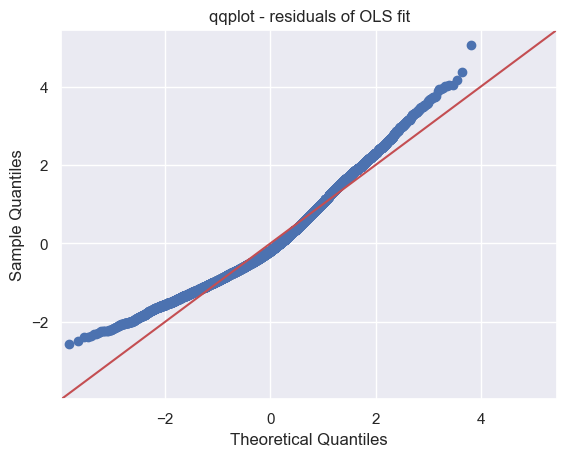

In [64]:
res = fit2.resid # residuals
probplot = sm.ProbPlot(res, stats.norm, fit = True)
fig = probplot.qqplot(line = '45')
h = plt.title('qqplot - residuals of OLS fit')
plt.show()

__Result:<br>
There is a pattern in Residual plots.<br>
There is a problem in the assumption or another variable can affect the burnt calories.<br>__

In [65]:
Reg3 = ols(formula = "Calories ~ Heart_Rate", data = data)
fit3 = Reg3.fit()
print(fit3.summary())

                            OLS Regression Results                            
Dep. Variable:               Calories   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                 6.239e+04
Date:                Thu, 27 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:37:56   Log-Likelihood:                -70993.
No. Observations:               15000   AIC:                         1.420e+05
Df Residuals:                   14998   BIC:                         1.420e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -469.4157      2.249   -208.714      0.0

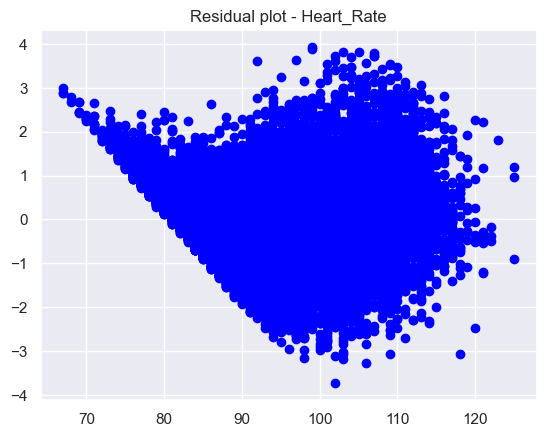

In [66]:
influence = fit3.get_influence()
resid_student = influence.resid_studentized_external
plt.figure()
plt.scatter(data['Heart_Rate'], resid_student, color = "blue")
plt.title('Residual plot - Heart_Rate')
plt.show()

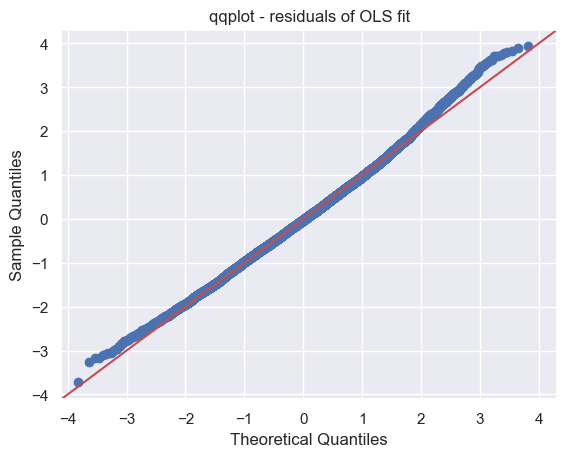

In [67]:
res = fit3.resid # residuals
probplot = sm.ProbPlot(res, stats.norm, fit = True)
fig = probplot.qqplot(line = '45')
h = plt.title('qqplot - residuals of OLS fit')
plt.show()

__Result:<br>
There is a pattern in Residual plots.<br>
Therefore the model is not valid.__

# 6.Linear Regression Analysis with Dummy variables

In [68]:
just_dummies = pd.get_dummies(data['Gender'])
step_1 = pd.concat([data, just_dummies], axis = 1)
step_1

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,female,male
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,0,1
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,1,0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,0,1
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,1,0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
14995,15644082,female,20,193.0,86.0,11.0,92.0,40.4,45.0,1,0
14996,17212577,female,27,165.0,65.0,6.0,85.0,39.2,23.0,1,0
14997,17271188,female,43,159.0,58.0,16.0,90.0,40.1,75.0,1,0
14998,18643037,male,78,193.0,97.0,2.0,84.0,38.3,11.0,0,1


In [69]:
step_1.drop(['Gender', 'female'], inplace = True, axis = 1)
step_1

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,male
0,14733363,68,190.0,94.0,29.0,105.0,40.8,231.0,1
1,14861698,20,166.0,60.0,14.0,94.0,40.3,66.0,0
2,11179863,69,179.0,79.0,5.0,88.0,38.7,26.0,1
3,16180408,34,179.0,71.0,13.0,100.0,40.5,71.0,0
4,17771927,27,154.0,58.0,10.0,81.0,39.8,35.0,0
...,...,...,...,...,...,...,...,...,...
14995,15644082,20,193.0,86.0,11.0,92.0,40.4,45.0,0
14996,17212577,27,165.0,65.0,6.0,85.0,39.2,23.0,0
14997,17271188,43,159.0,58.0,16.0,90.0,40.1,75.0,0
14998,18643037,78,193.0,97.0,2.0,84.0,38.3,11.0,1


In [70]:
result = sm.OLS(step_1['Calories'], sm.add_constant(step_1[['Duration', 'male']])).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               Calories   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 7.893e+04
Date:                Thu, 27 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:38:37   Log-Likelihood:                -64965.
No. Observations:               15000   AIC:                         1.299e+05
Df Residuals:                   14997   BIC:                         1.300e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -23.0321      0.351    -65.630      0.0

__E(Calories | male) = -23.0321 + 7.1722 Duration + 2.3803 male <br>
E(Calories | female) = -23.0321 + 7.1722 Duration <br>
The result shows that burnt calories by males are 2.3803 times higher than those burnt by females if the Duration is constant.__

In [71]:
result1 = sm.OLS(step_1['Calories'], sm.add_constant(step_1[['Body_Temp', 'male']])).fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:               Calories   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                 1.595e+04
Date:                Thu, 27 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:38:37   Log-Likelihood:                -74749.
No. Observations:               15000   AIC:                         1.495e+05
Df Residuals:                   14997   BIC:                         1.495e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2556.3516     14.817   -172.526      0.0

__E(Calories | male) = -2556.3516  + 66.0799 Body_Temp +  2.0428 male <br>
E(Calories | female) = -2556.3516 + 66.0799 Body_Temp <br>
The result shows that the Calories burnt by males are  2.0428 times higher than those burnt by females if the Body_Temp is constant.__

In [72]:
result2 = sm.OLS(step_1['Calories'], sm.add_constant(step_1[['Heart_Rate', 'male']])).fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:               Calories   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                 3.122e+04
Date:                Thu, 27 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:38:37   Log-Likelihood:                -70988.
No. Observations:               15000   AIC:                         1.420e+05
Df Residuals:                   14997   BIC:                         1.420e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -470.0730      2.257   -208.278      0.0

__E(Calories | male) = -470.0730  + 5.8509 Heart_Rate +  1.4974 male <br>
E(Calories | female) = -470.0730 + 5.8509 Heart_Rate <br>
The result shows that the Calories burnt by male are  1.4974 times higher than those burnt by female if the Heart_Rate is constant.__

# 7.XGBoost model

In [73]:
data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [74]:
# Create Dummy variables
data.replace({'Gender':{'male' :0, 'female':1}}, inplace = True)
data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,0,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,1,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,0,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,1,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,1,27,154.0,58.0,10.0,81.0,39.8,35.0


In [75]:
# Define X and Y
X = data.drop(columns = ['User_ID', 'Calories'], axis = 1)
Y = data['Calories'].copy()

In [76]:
print(X)

       Gender  Age  Height  Weight  Duration  Heart_Rate  Body_Temp
0           0   68   190.0    94.0      29.0       105.0       40.8
1           1   20   166.0    60.0      14.0        94.0       40.3
2           0   69   179.0    79.0       5.0        88.0       38.7
3           1   34   179.0    71.0      13.0       100.0       40.5
4           1   27   154.0    58.0      10.0        81.0       39.8
...       ...  ...     ...     ...       ...         ...        ...
14995       1   20   193.0    86.0      11.0        92.0       40.4
14996       1   27   165.0    65.0       6.0        85.0       39.2
14997       1   43   159.0    58.0      16.0        90.0       40.1
14998       0   78   193.0    97.0       2.0        84.0       38.3
14999       0   63   173.0    79.0      18.0        92.0       40.5

[15000 rows x 7 columns]


In [77]:
print(Y)

0        231.0
1         66.0
2         26.0
3         71.0
4         35.0
         ...  
14995     45.0
14996     23.0
14997     75.0
14998     11.0
14999     98.0
Name: Calories, Length: 15000, dtype: float64


In [78]:
# Split the data into Train/Test set
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.30, random_state=42)

In [79]:
print(X.shape, X_train.shape, X_test.shape)

(15000, 7) (10500, 7) (4500, 7)


In [80]:
# Create the model
model = xgb.XGBRegressor()

In [81]:
# Fit the model with train data
model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [82]:
# Predict X_test by the model
test_data_prediction = model.predict(X_test)
test_data_prediction

array([173.28725, 188.32124,  50.69697, ...,  28.63218, 196.50165,
       137.67964], dtype=float32)

In [83]:
# Validation
import sklearn.metrics as metrics
mean_abs_error = metrics.mean_absolute_error(Y_test, test_data_prediction)
mean_abs_error

1.5346040989889038

In [84]:
MSE = metrics.mean_squared_error(Y_test, test_data_prediction)
MSE

4.906107833239174

In [85]:
RMSE = np.sqrt(MSE)
RMSE

2.2149735513633506

In [86]:
R2 = metrics.r2_score(Y_test, test_data_prediction)
R2

0.9987567086811175

In [87]:
n_test = len(Y_test)
p_variables = 7
Adj_R2 = 1-(1-R2)*(n_test-1)/(n_test - p_variables-1)
Adj_R2

0.9987547712280382

In [88]:
# Residual Analysis
test_predictions = model.predict(X_test)

In [89]:
test_res = Y_test - test_predictions
test_res

11499   -0.287247
6475     0.678757
13167    2.303028
862      1.273026
5970     2.652924
           ...   
4217    -3.651909
13886   -0.029930
10464    1.367821
6902     1.498352
4874     0.320358
Name: Calories, Length: 4500, dtype: float64

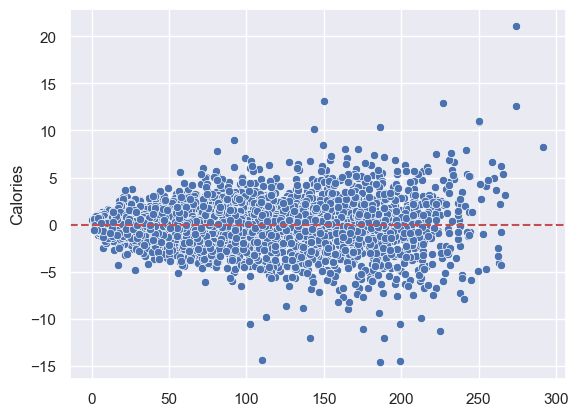

In [90]:
# The look should be random
sns.scatterplot(x=test_predictions,y=test_res)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

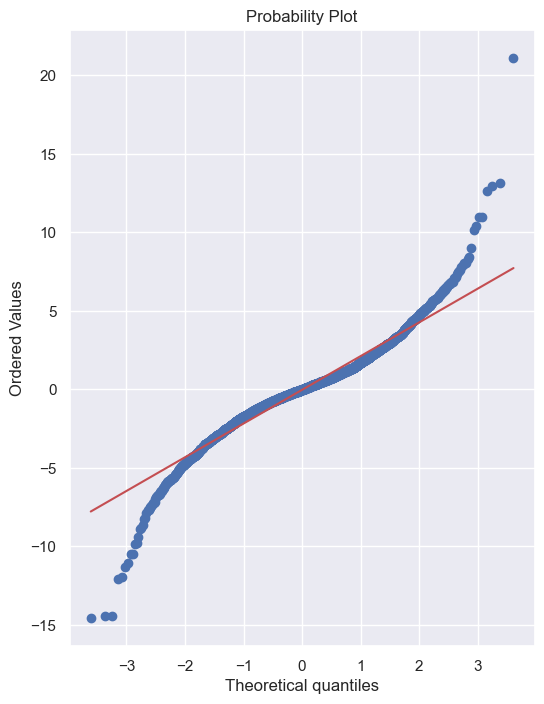

In [91]:
import scipy as sp
# Create a figure and axis to plot on
fig, ax = plt.subplots(figsize=(6,8),dpi=100)
# probplot returns the raw values if needed
# we just want to see the plot, so we assign these values to _
_ = sp.stats.probplot(test_res,plot=ax)

# 8.Final Model

In [92]:
final_model = xgb.XGBRegressor()
final_model.fit(X,Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [93]:
# Final model - prediction
test_data_prediction = final_model.predict(X)
test_data_prediction

array([231.45078 ,  67.098785,  26.130308, ...,  74.64482 ,  10.996041,
        96.59136 ], dtype=float32)

In [94]:
# Validation
import sklearn.metrics as metrics
mean_abs_error = metrics.mean_absolute_error(Y, test_data_prediction)
mean_abs_error

0.9911418662048876

In [95]:
MSE = metrics.mean_squared_error(Y, test_data_prediction)
MSE

1.8287397207213907

In [96]:
RMSE = np.sqrt(MSE)
RMSE

1.3523090329955616

In [97]:
R2 = metrics.r2_score(Y, test_data_prediction)
R2

0.999531117399604

In [98]:
n_test = len(Y)
p_variables = 7
Adj_R2 = 1-(1-R2)*(n_test-1)/(n_test - p_variables-1)
Adj_R2

0.9995308984709619

In [99]:
# Residual Analysis
test_predictions = final_model.predict(X)

In [100]:
test_res = Y - test_predictions
test_res

0       -0.450775
1       -1.098785
2       -0.130308
3        0.630669
4        1.196556
           ...   
14995    0.135387
14996    1.552980
14997    0.355179
14998    0.003959
14999    1.408638
Name: Calories, Length: 15000, dtype: float64

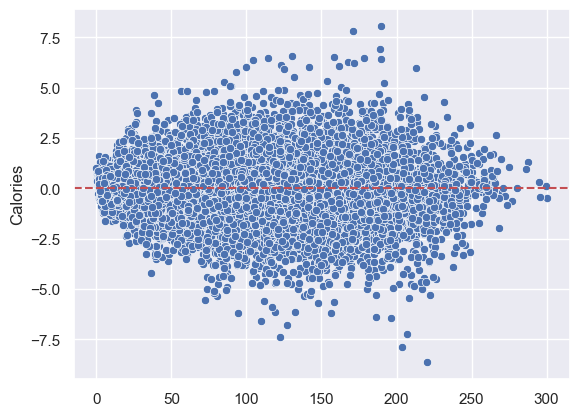

In [101]:
# The look should be random
sns.scatterplot(x=test_predictions,y=test_res)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

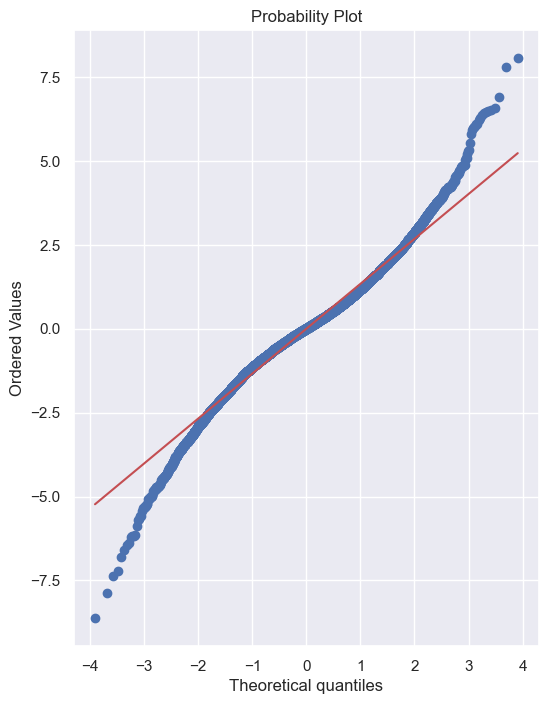

In [102]:
import scipy as sp
# Create a figure and axis to plot on
fig, ax = plt.subplots(figsize=(6,8),dpi=100)
# probplot returns the raw values if needed
# we just want to see the plot, so we assign these values to _
_ = sp.stats.probplot(test_res,plot=ax)

# 9.Building a Predictive System

In [103]:
data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,0,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,1,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,0,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,1,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,1,27,154.0,58.0,10.0,81.0,39.8,35.0


__Predict the calories burnt by Gender: Man, Age: 68, Height: 190, Weight: 94, Duration: 29, Heart_Rate: 105, Body_Temp: 40.8__

In [104]:
input_ = (0, 68, 190, 94, 29, 105, 40.8)
input_arr = np.asarray(input_)
input_reshaped = input_arr.reshape(1,-1)
prediction = final_model.predict(input_reshaped)
print(f'Predicted Burnt Calories: {prediction}')

Predicted Burnt Calories: [231.45078]


__Predict the calories burnt by Gender: Man, Age: 30, Height: 180, Weight: 80, Duration: 30, Heart_Rate: 100, Body_Temp: 40__

In [105]:
input_ = (0, 30, 180.0, 80, 30.0, 100.0, 40.0)
input_arr = np.asarray(input_)
input_reshaped = input_arr.reshape(1,-1)
prediction = final_model.predict(input_reshaped)
print(f'Predicted Burnt Calories: {prediction}')

Predicted Burnt Calories: [155.37668]
